In [1]:
import warnings

warnings.filterwarnings(action='ignore')

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_ef import FCFE
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [2]:
data_set = ChangeDetectionDataset('../data/annotated',
                                  '../data/patch_train.csv',
                                  concat=True
                                  )

In [3]:
len(data_set)

27054

torch.Size([6, 96, 96]) torch.Size([96, 96])


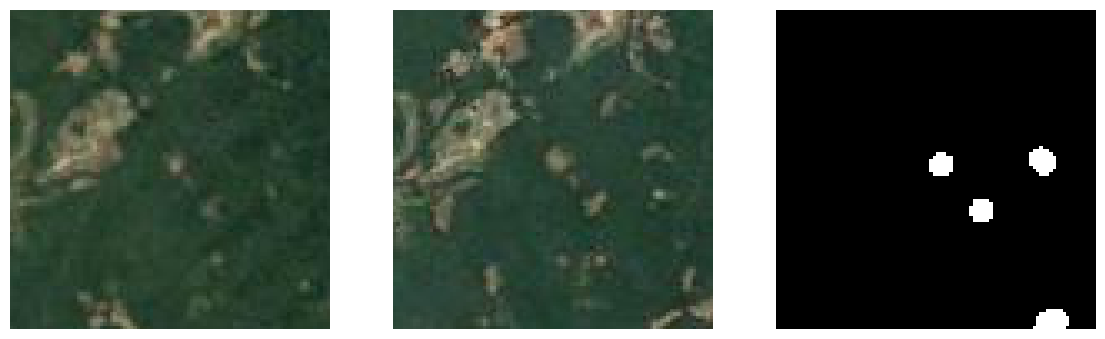

In [4]:
img, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(img[:3, ::].permute(1, 2, 0).numpy())
axes[1].imshow(img[3:, ::].permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

print(img.shape, label.shape)

In [5]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(677, 170)

### Modeling

In [6]:
model = FCFE(6, 3, classes=2)

In [7]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=50)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [8]:
compiled.summary((6, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             880
       BatchNorm2d-2           [-1, 16, 96, 96]              32
           Dropout-3           [-1, 16, 96, 96]               0
            Conv2d-4           [-1, 16, 96, 96]           2,320
       BatchNorm2d-5           [-1, 16, 96, 96]              32
           Dropout-6           [-1, 16, 96, 96]               0
         MaxPool2d-7           [-1, 16, 48, 48]               0
            Conv2d-8           [-1, 32, 48, 48]           4,640
       BatchNorm2d-9           [-1, 32, 48, 48]              64
          Dropout-10           [-1, 32, 48, 48]               0
           Conv2d-11           [-1, 32, 48, 48]           9,248
      BatchNorm2d-12           [-1, 32, 48, 48]              64
          Dropout-13           [-1, 32, 48, 48]               0
        MaxPool2d-14           [-1, 32,

In [ ]:
weights = torch.FloatTensor([0.5, 1]).cuda()

results = compiled.train(train_dataloader,
                         nn.NLLLoss(weights),
                         50,
                         test_dataloader)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.3738855429687035


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.21207093456212212


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.18490978992892157


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.2210372868048794


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.1713396011352363


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.25784412550137326


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.16686044419885915


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.3712229299632942


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.16354755775527025


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.21424920835039196


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.1618676800253296


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.25618625861756944


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.15872697962483767


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.1988355793935411


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.15838735669499135


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.2138989401214263


Training:   0%|          | 0/677 [00:00<?, ?it/s]

train loss: 0.15701016191629752


Validation:   0%|          | 0/170 [00:00<?, ?it/s]

val loss: 0.20911084323683204


Training:   0%|          | 0/677 [00:00<?, ?it/s]

In [ ]:
torch.save(model, "../checkpoints/fcfe/final-model.pth")

In [ ]:
plt.figure(figsize=[12, 6], dpi=200)
sns.lineplot(x='epoch', y='train loss', data=results, label='train')
sns.lineplot(x='epoch', y='val loss', data=results, label='validation')
plt.show()

In [ ]:
i = np.random.randint(0, len(test_dataset))
img = test_dataset[i][0]

with torch.no_grad():
    model.eval()
    logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[i][1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')

In [ ]:
pixel_accuracy(test_dataset[i][1], pred), kappa(test_dataset[i][1], pred)